In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random as rd
import time

sys.path.append("..")
tf.random.set_seed(1234)

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

## Load dataset

In [2]:
x, y = pp.read_dataset('x_train.txt', 'y_train.txt')

train_dataset, val_dataset = pp.train_dataset(x[:100], y[:100], 10, 90, 10) #val_len, train_batch, val_batch

## Define the model: 
### the first argument is the number of Henon maps, the second argument can be either 'reversible' or 'non-reversible' to generate a model that is either a time-reversible composition of Henon maps or a random composition of Henon maps respectively.

In [3]:
model1R = rs.Henon(15, 'reversible')

## Callback function for decaying learning rate

In [4]:
def scheduler(epoch, lr):
    if epoch%100==0:
        print("epoch: ", epoch)
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.0006)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Checkpoints

In [5]:
checkpoint_path_1R = "checkpoints_PP_HH_1R_01/cp.ckpt"
checkpoint_dir_1R = os.path.dirname(checkpoint_path_1R)

cp_callback_1R = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1R,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=0)

## Training

In [6]:
model1R.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=["accuracy"],
)

Epochs = 3000
t=time.time()
history1R = model1R.fit(train_dataset, epochs = Epochs, validation_data=val_dataset, callbacks=[callback, cp_callback_1R], verbose=0)
print("Training time:" + str(time.time()-t))

epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
Training time:166.73079299926758


## Load best model

In [7]:
model1R.load_weights(checkpoint_path_1R)

## Plot the loss and save it as a .txt file

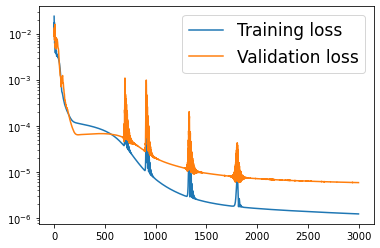

In [8]:
os.remove("PP_HH_Loss.txt")
f = open("PP_HH_Loss.txt", "a")
for i in history1R.history["loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

os.remove("PP_HH_Val.txt")
f = open("PP_HH_Val.txt", "a")
for i in history1R.history["val_loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

plt.plot(history1R.history["loss"], label="Training loss")
plt.plot(history1R.history["val_loss"], label="Validation loss")
plt.yscale("log")
plt.legend(fontsize=17)
plt.show()

## Poincare plot

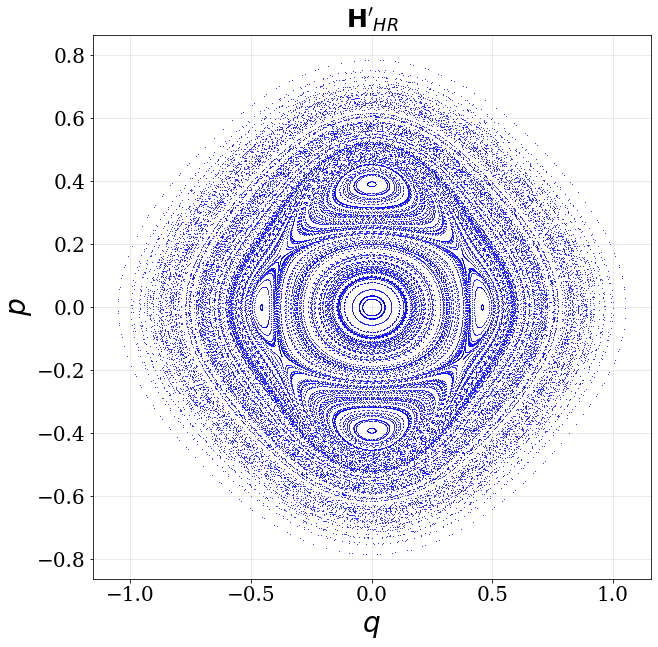

In [22]:
N = 300

x0 = np.array([[rd.randrange(-600, 600, 1)*0.001, rd.randrange(-600, 600, 1)*0.001] for _ in range(N)])
iterations = [model1R(x0)]
for _ in range(200):
    iterations.append(model1R(iterations[-1]))
    
plt.figure(figsize=(10,10))
plt.rc('font', family='serif')
plt.title("$\mathbf{H}'_{HR}$", fontsize = 25)

plt.scatter(*zip(*iterations[0].numpy()), s=1, linewidth=0, color="b", label = "Iterations")

        
for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color="b")
    
#plt.scatter(*zip(*x0), s=10, linewidth=0, color="r", label = "Starting points")
plt.xlabel(r'$q$', fontsize=28, labelpad=8)
plt.ylabel(r'$p$', fontsize=28, labelpad=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=20)
#lgnd.legendHandles[0]._sizes = [15]
#lgnd.legendHandles[1]._sizes = [30]
plt.savefig("Test_PP_HM")
plt.show()

## Future state prediction

In [2]:
from scipy.integrate import odeint
from scipy.misc import derivative


## Hamiltonian system for numerical integration

In [3]:
def pend(y, t):
     q, p  = y
     dydt = [- p + 0.5*(0.3*q*np.sin(2*t) + 0.7*q*np.sin(3*t)), 0.25*np.sin(q) - 0.5*(0.3*p*np.sin(2*t) + 0.7*p*np.sin(3*t))]
     return dydt


def Tau(y0):
    sol = odeint(pend, y0, np.linspace(0, 2*np.pi, 1000))
    return sol[-1]

## Starting points

In [14]:
N_predictions = 180
x0 = np.array([[rd.randrange(-600, 600, 1)*0.001, rd.randrange(-600, 600, 1)*0.001] for _ in range(100)])
#x0 = np.array([[0.0, 0.1],[0.0, 0.2],[0.0, 0.3],[0.0, 0.4],[0.0, 0.5],[0.0, 0.6],[0.1, 0.],[0.2, 0.],[0.3, 0.],[0.4, 0.],[0.5, 0.]])

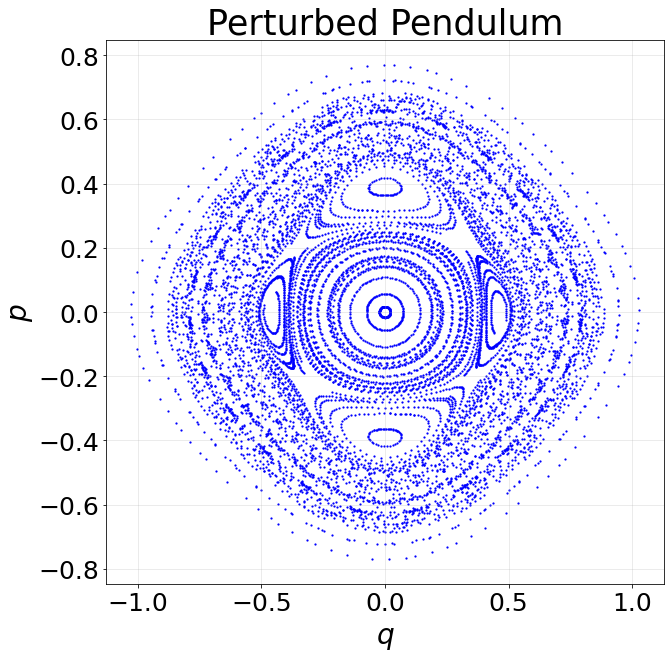

In [16]:
plt.figure(figsize=(10,10))
plt.title(r'Perturbed Pendulum', fontsize = 35)
plt.scatter([Tu[i][0] for i in range(len(Tu))], [Tu[i][1] for i in range(len(Tu))], s=5, color = "b", linewidth=0)
plt.xlabel(r'$q$', fontsize=28, labelpad=8)
plt.ylabel(r'$p$', fontsize=28, labelpad=3)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(axis='both', alpha=.3)
plt.savefig("True_Poincare_Plot")
plt.show()

## Numerical integration

In [15]:
Tu = []
for u in x0:
    a = Tau(u)
    Tu.append(a)
    for i in range(100):
        a = Tau(a)
        Tu.append(a)

## Using the trained evolution map

In [29]:
iterations1R = [model1R(x0)]
for _ in range(N_predictions):
    iterations1R.append(model1R(iterations1R[-1]))

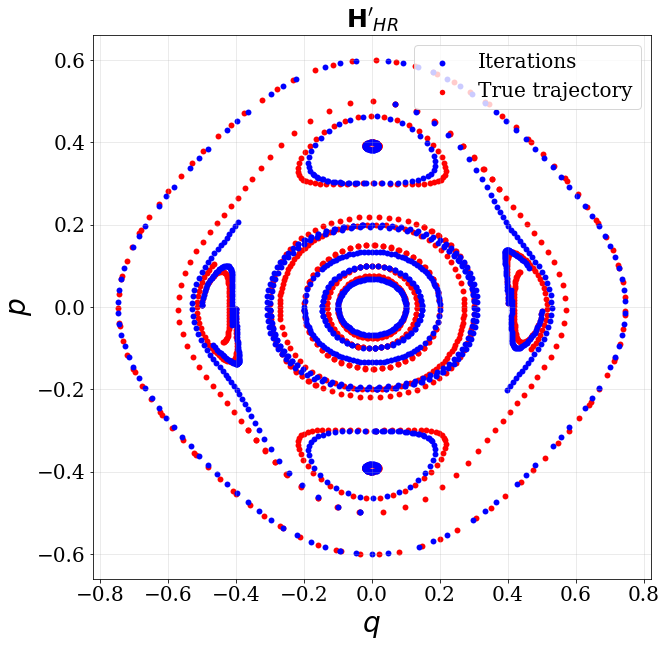

In [30]:
plt.figure(figsize=(10,10))
plt.rc('font', family='serif')
plt.title("$\mathbf{H}'_{HR}$", fontsize = 25)
    
for i in Tu:
    plt.scatter(i[0], i[1], s=35, linewidth=0, color="r")


plt.scatter(*zip(*iterations1R[0].numpy()), s=35, linewidth=0, color="b", label = "Iterations")

for i in iterations1R:
    plt.scatter(*zip(*i.numpy()), s=35, linewidth=0, color="b")


plt.scatter(i[0][0], i[0][1], s=35, linewidth=0, color="r", label="True trajectory")
    
#plt.scatter(*zip(*x0), s=20, linewidth=0, color="r", label = "Starting points")

plt.xlabel(r'$q$', fontsize=28, labelpad=8)
plt.ylabel(r'$p$', fontsize=28, labelpad=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=20)
lgnd.legendHandles[0]._sizes = [35]
lgnd.legendHandles[1]._sizes = [30]
plt.savefig("Iteration_Test_PP_HM")
plt.show()

## Errors

In [31]:
errors = []
for u in x0:
    error = []
    Taus = [u]
    models = [[u]]
    for _ in range(30):
        error.append(tf.norm(Tau(Taus[-1]) - model1R(models[-1])[0]).numpy())
        Taus.append(Tau(Taus[-1]))
        models.append(model1R(models[-1]))
    errors.append(error)

In [32]:
avg_error = []
for i in range(30):
    avg = 0
    for p in errors:
        avg = avg + p[i]
    avg_error.append(avg/len(errors))

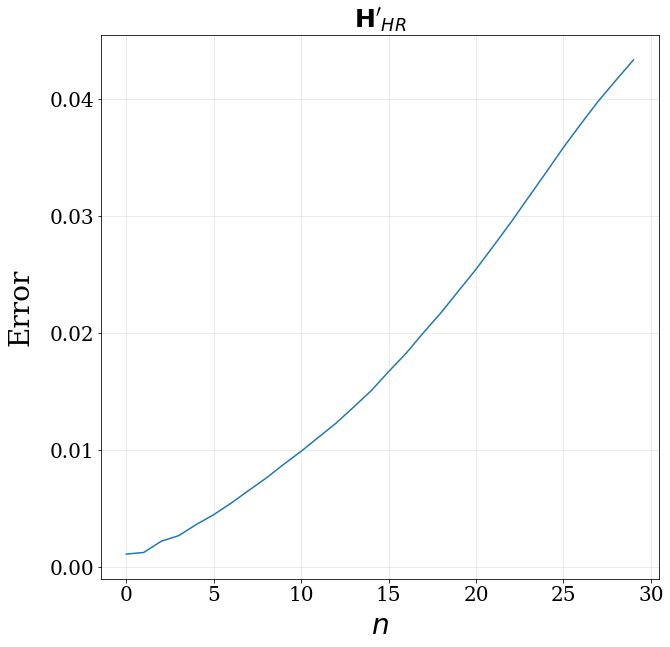

In [33]:
plt.figure(figsize=(10,10))
plt.rc('font', family='serif')
plt.title("$\mathbf{H}'_{HR}$", fontsize = 25)

plt.plot(avg_error)

plt.xlabel(r'$n$', fontsize=28, labelpad=8)
plt.ylabel(r'Error', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=20)
#lgnd.legendHandles[0]._sizes = [15]
#lgnd.legendHandles[1]._sizes = [30]
plt.savefig("Error_Test_PP_HM")
plt.show()

In [37]:
os.remove("PP_HM_error.txt")
f = open("PP_HM_error.txt", "a")
for i in avg_error:
        f.write(str(i))
        f.write("\n")
f.close()